# Cloud-induced changes in atmospheric radiative heating from 4 models

This notebook reproduces Figure 7.

Data:

 * The cloud-induced heating changes are diagnosed by PRP simulations.
 * CAM4 and MPI-ESM-LR data is from 2xCO2 simulations of Ceppi and Shepherd, 2017, Contributions of Climate Feedbacks to Changes in Atmospheric Circulation, Journal of Climate, doi:10.1175/JCLI-D-17-0189.1.
 * IPSL-CM5A-LR and ICON-NWP arefrom +4K SST simulations of Voigt et al., 2019, The Atmospheric Pathway of the Cloud-Radiative Impact on the Circulation Response to Global Warming: Important and Uncertain, Journal of Climate, doi:10.1175/JCLI-D-18-0810.1.

### Load libraries

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

### Load heating and cloud-cover changes for the models

The heating and cloud cover changes are stored in a list of datasets, called ds_list:

In [2]:
ds_list=[]

Cloud fields might live on a different vertical grid than radiative heating rates, and so the vertical grid of the cloud data is stored as lev_dcld. Also note that we normalize by the global-mean surface warming, whose values are:
 * CAM4: 3.06
 * MPI-ESM-LR: 2.80
 * IPSL-CM5A-LR: 4.6
 * ICON-NWP: 4.5

**CAM4**

In [3]:
ds_dQcld = ( xr.load_dataset('../../data/climatechange/cam4_echam6_cloud_radiative_heating.nc')[['lat_1', 'lev_1', 'dQcld_cam4']].
             rename({'lev_1': 'lev', 'lat_1': 'lat', 'dQcld_cam4': 'dQcld'}) )

ds_dcld  = ( xr.load_dataset('../../data/climatechange/cam4_cloud_2xco2_minus_ctrl.nc')[['lat', 'lev', 'CLOUD']].
             rename({'lat': 'lat_dcld', 'lev': 'lev_dcld', 'CLOUD': 'dcld'}). squeeze() )
ds_dcld['dcld'] = 100*ds_dcld['dcld']

ds_tropp = ( xr.load_dataset('../../data/climatechange/cam4_echam6_tropopause.nc')[['lat_1', 'p_trop_cam4']].
             rename({'lat_1': 'lat', 'p_trop_cam4': 'p_trop'}) )
ds_tropp['dtsurf'] = 3.06    # add global mean sfc warming to dataset
ds_tropp['model']  = 'CAM4' # add model name

ds_list.append(xr.merge([ds_dQcld, ds_dcld, ds_tropp]))
del ds_dQcld, ds_dcld, ds_tropp

**MPI-ESM-LR**

In [4]:
ds_dQcld = ( xr.load_dataset('../../data/climatechange/cam4_echam6_cloud_radiative_heating.nc')[['lat_2', 'lev_2', 'dQcld_echam6']].
             rename({'lev_2': 'lev', 'lat_2': 'lat', 'dQcld_echam6': 'dQcld'}) )

ds_dcld  = ( xr.load_dataset('../../data/climatechange/echam6_cloud_2xco2_minus_ctrl.nc')[['lat', 'lev', 'aclcac']].
             rename({'lat': 'lat_dcld', 'lev': 'lev_dcld', 'aclcac': 'dcld'}). squeeze() )
ds_dcld['dcld'] = 100*ds_dcld['dcld']
ds_dcld['lev_dcld'] = 0.01*ds_dcld['lev_dcld']


ds_tropp = ( xr.load_dataset('../../data/climatechange/cam4_echam6_tropopause.nc')[['lat_1', 'p_trop_echam6']].
             rename({'lat_2': 'lat', 'p_trop_echam6': 'p_trop'}) )
ds_tropp['dtsurf'] = 2.80         # add global mean sfc warming to dataset
ds_tropp['model']  = 'MPI-ESM-LR' # add model name

ds_list.append(xr.merge([ds_dQcld, ds_dcld, ds_tropp]))
del ds_dQcld, ds_dcld, ds_tropp

**IPSL-CM5A-LR**

In [5]:
def get_ds_dQcld_ipsl():
    # control simulation with forward PRP
    ds_dQcld1 = ( xr.load_dataset('../../data/climatechange/l5aam001_20100101_20151230_1M_histmth.withprp.zonmean.timmean.nc')
                  [['lat', 'presnivs', 'dtswr', 'dtlwr', 'dtswr_prpc', 'dtlwr_prpc', 'rneb']].
                  rename({'presnivs': 'lev', 'rneb': 'cld'}).squeeze() )
    ds_dQcld1['lev'] = ds_dQcld1['lev']/100
    ds_dQcld1['dQcld'] = 86400 * ( (ds_dQcld1['dtswr_prpc']+ds_dQcld1['dtlwr_prpc']) - 
                                   (ds_dQcld1['dtswr']+ds_dQcld1['dtlwr']) )
    # +4K simulation with backward PRP
    ds_dQcld2 = ( xr.load_dataset('../../data/climatechange/l5aam002_20100101_20151230_1M_histmth.withprp.zonmean.timmean.nc')
                  [['lat', 'presnivs', 'dtswr', 'dtlwr', 'dtswr_prpc', 'dtlwr_prpc', 'rneb']].
                  rename({'presnivs': 'lev', 'rneb': 'cld'}).squeeze() )
    ds_dQcld2['lev'] = ds_dQcld2['lev']/100
    ds_dQcld2['dQcld'] = -86400 * ( (ds_dQcld2['dtswr_prpc']+ds_dQcld2['dtlwr_prpc']) - 
                                    (ds_dQcld2['dtswr']+ds_dQcld2['dtlwr']) )
    # mean PRP; cloud cover change 
    ds_dQcld = 0*ds_dQcld1
    ds_dQcld['dQcld'] = 0.5*(ds_dQcld1['dQcld']+ds_dQcld2['dQcld']) 
    
    return ds_dQcld

ds_dQcld = get_ds_dQcld_ipsl()  

def get_ds_dcld_ipsl():
    # control simulation
    ds_cld1 = ( xr.load_dataset('../../data/climatechange/l5aam001_20100101_20151230_1M_histmth.withprp.zonmean.timmean.nc')
                [['lat', 'presnivs', 'rneb', 'rneb']].
                rename({'lat': 'lat_dcld', 'presnivs': 'lev_dcld', 'rneb': 'cld'}).squeeze() )
    ds_cld1['lev_dcld'] = ds_cld1['lev_dcld']/100
    # +4K simulation
    ds_cld2 = ( xr.load_dataset('../../data/climatechange/l5aam002_20100101_20151230_1M_histmth.withprp.zonmean.timmean.nc')
                [['lat', 'presnivs', 'rneb']].
                rename({'lat': 'lat_dcld', 'presnivs': 'lev_dcld', 'rneb': 'cld'}).squeeze() )
    ds_cld2['lev_dcld'] = ds_cld2['lev_dcld']/100

    ds_dcld = 0*ds_cld1
    ds_dcld['dcld'] = 100 * (ds_cld2['cld'] - ds_cld1['cld'])
    ds_dcld = ds_dcld[['lat_dcld', 'lev_dcld', 'dcld']]
    
    return ds_dcld    

ds_dcld  = get_ds_dcld_ipsl()  

ds_tropp = ( xr.load_dataset('../../data/climatechange/l5aam001_tropopause_zonaltimemean.nc')[['lat', 'ptrop']].
             rename({'ptrop': 'p_trop'}).squeeze() )
ds_tropp['p_trop'] = ds_tropp['p_trop']/100
ds_tropp['dtsurf'] = 4.6            # add global mean sfc warming to dataset
ds_tropp['model']  = 'IPSL-CM5A-LR' # add model name

ds_list.append(xr.merge([ds_dQcld, ds_dcld, ds_tropp]))
del ds_dQcld, ds_dcld, ds_tropp

**ICON-NWP**

In [6]:
ds_dQcld = ( xr.load_dataset('../../data/climatechange/ICON-NWP_prp_AMIP_free_prpfields_3d_mm_zonmean.timmean.nc')[['dQ_c_srad', 'dQ_c_trad']].squeeze() )
ds_dQcld['dQcld'] = 86400*(ds_dQcld['dQ_c_srad']+ds_dQcld['dQ_c_trad'])
ds_dQcld['lev'] = ds_dQcld['lev']/100

ds_dcld = ( xr.load_dataset('../../data/climatechange/ICON-NWP.AMIP4K_free-minus-AMIP_free.clc.zonmean.timmean.nc').
            rename({'lat': 'lat_dcld', 'lev': 'lev_dcld', 'clc': 'dcld'}).squeeze())
ds_dcld['lev_dcld'] = ds_dcld['lev_dcld']/100

ds_tropp = ( xr.load_dataset('../../data/climatechange/ICON-NWP_AMIP_free_tropopause_zonaltimemean.nc')[['lat', 'ptrop']].
             rename({'ptrop': 'p_trop'}).squeeze() )
ds_tropp['p_trop'] = ds_tropp['p_trop']/100
ds_tropp['dtsurf'] = 4.5        # add global mean sfc warming to dataset
ds_tropp['model']  = 'ICON-NWP' # add model name

ds_list.append(xr.merge([ds_dQcld, ds_dcld, ds_tropp], compat='override'))
del ds_dQcld, ds_dcld, ds_tropp

### Plotting

In [7]:
clev_dt   = [-0.25, -0.2, -0.15, -0.1, -0.05, -0.03, -0.01, 0.01, 0.03, 0.05, 0.1, 0.15, 0.20 ,0.25]
clev_dcld = 0.5*np.array([-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7])

Plot all 4 models: CAM4, MPI-ESM-LR, IPSL-CM5A-LR, ICON-NWP

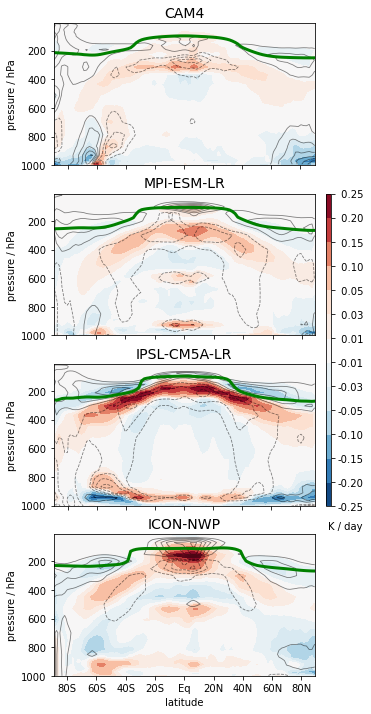

In [8]:
fig=plt.figure(figsize=(5,12))

for counter in [0, 1, 2, 3]:

    ds = ds_list[counter]
    plt.subplot(4,1,counter+1)
    ax=plt.subplot2grid((4,1),(counter,0), colspan=1,rowspan=1)
    
    dQcld_plot = ds['dQcld'].values / ds['dtsurf'].values
    dQcld_plot[dQcld_plot>=0.25]=0.25
    dQcld_plot[dQcld_plot<=-0.25]=-0.25
    c=plt.contourf(ds['lat'], ds['lev'], dQcld_plot, clev_dt, 
                 cmap='RdBu_r')
    fig.subplots_adjust(right=0.85)
    plt.plot(ds['lat'], ds['p_trop'], 'green', linewidth=3)
    plt.ylim(1000,10)
    plt.contour(ds['lat_dcld'], ds['lev_dcld'], ds['dcld']/ds['dtsurf'] , 
                clev_dcld, colors='k', linewidths=0.8, alpha=0.5)
    plt.xticks([-80, -60, -40, -20, 0, 20, 40, 60, 80],
            [''], fontsize=10)
    if ds['model'] == 'ICON-NWP':
        plt.xlabel('latitude', fontsize=10)
        plt.xticks([-80, -60, -40, -20, 0, 20, 40, 60, 80],
               ['80S','60S', '40S', '20S', 'Eq', '20N', '40N', '60N', '80N'], fontsize=10)
    plt.title(str(ds['model'].values), fontsize=14)
    plt.ylabel('pressure / hPa', fontsize=10)
    
    # add colorbar, note that colorbar needs to be done last, as otherwise it seems
    # to mess up axis information
    if ds['model']=='MPI-ESM-LR':
        cbar_ax = fig.add_axes([0.88, 0.321, 0.015, 0.362])
        cbar=plt.colorbar(c , cax=cbar_ax, orientation='vertical')
        cbar.set_ticks(clev_dt)
        cbar.set_ticklabels(['-0.25', '-0.20', '-0.15', '-0.10', '-0.05', '-0.03', '-0.01', 
                             ' 0.01', ' 0.03', ' 0.05', ' 0.10', ' 0.15', ' 0.20' ,' 0.25'])
        plt.text(1.05,-1.37,'K / day', transform = ax.transAxes,backgroundcolor='none',fontsize=10)
        
plt.savefig('./figure-7.pdf')